<a href="https://colab.research.google.com/github/andrileu/IoN_exercises/blob/main/11_learning_in_ANNs_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise session 11: Learning in Artificial Neural Networks (ANNs)

This exercise session will explore the learning mechanisms behind artificial neural networks.
The first part covers the classic single-layer Perceptron and its learning algorithm.
The second part introduces modern artificial neural networks and the concept of gradient descent.
In the third part, we gain a deeper intuition of what artificial neural networks learn.
The fourth part showcases a real-world artificial neural network called a GAN.
The final part demonstrates available pre-trained GANs.

## Setup

In [1]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.1 MB/s eta 0:00:00


Next, we download additional files required by this tutorial.

In [2]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
print(f"IN_COLAB: {IN_COLAB}")

IN_COLAB: True


In [3]:
if IN_COLAB:
    # Download util scripts
    !mkdir utils_ex11
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/gd_bp.py
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/gan.py
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/p.py
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/gan_pretrain.py
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/imagenet_classes.py
    # Download figures
    !mkdir utils_ex11/Figures
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/Figures/gan.png
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/Figures/nn.png
    !wget -P utils_ex11/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/Figures/perceptron.png

--2025-01-04 14:33:50--  https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex11/gd_bp.py
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex11/gd_bp.py [following]
--2025-01-04 14:33:51--  https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex11/gd_bp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29892 (29K) [text/plain]
Saving to: ‘utils_ex11/gd_bp.py’

gd_bp.py            100%[===================>]  29.19K  --.-KB/s    in 0.002s  

2025-01-04 14:33:51 (16.3 MB/s) - ‘utils_ex11/

Install dependencies

In [4]:
!pip install mlxtend
!pip install ipython
!pip install pytorch-pretrained-biggan
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 8.4 MB/s eta 0:00:00


In [5]:
if IN_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax.random as jrandom

from utils_ex11.p import *
from utils_ex11.gd_bp import *
from utils_ex11.gan import *
from utils_ex11.gan_pretrain import *

/content/utils_ex11/gan.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# 1. Perceptron

The Perceptron is considered one of the earliest artificial neural networks and played a significant role in the development of machine learning. Introduced by Frank Rosenblatt in 1958, it was inspired by the idea of mimicking basic biological neural processes. The Perceptron demonstrated that a machine could learn from data using adjustable weights, establishing a framework for early neural network research.

## 1.1 Classic, single-layer Perceptron

### 1.1.1 Model

With today's nomenclature, the classic, single-layer Perceptron is a **neural network with a binary activation function (binary neuron), no hidden layer, and a model-specific learning algorithm**.

The single-layer Perceptron model is the following:

$\hat{y} = h(\vec{x} \cdot \vec{\beta}^T) = h(\sum_i x_i * \beta_{i})$

Where $h$ is the binary activation function, $x$ is the input, and $\beta$ are the weights (learnable parameters).
$\hat{y}$ is the predicted output ($0$ or $1$) for one of the two classes.

Visually (Note: $w$ is $\beta$):

<img src="https://github.com/ManteLab/ItoN_notebooks_public/blob/main/utils_ex11/Figures/perceptron.png?raw=1" alt="drawing" width="500px"/>

$\vec{x} \cdot \vec{\beta}^T$ is the inner vector product, which is defined as $\sum_i x_i * \beta_{i}$.

$h$ is the [Heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function), which is $1$ if $\vec{x} \cdot \vec{\beta}^T$ is positive and $0$ if $\vec{x} \cdot \vec{\beta}^T$ is negative. The inner product $\vec{x} \cdot \vec{\beta}^T$ is positive if the vector points in the same direction and negative if they point in opposite directions.

### 1.1.2 (Linear) Classification

The Classic Perceptron learns to discriminate using a linear decision boundary given data.
Thus, the model can learn linear classification as shown below.

Given an input point ($x_1$, $x_2$), the Perceptron model predicts either the blue class $0$ or the orange class $1$. For example, for the input $x_1=1$ and $x_2=2$, the model predicts $1$ as it is in the orange area. The model was trained on the shown data points.

In [7]:
show_linear_model(interactive=False)

Output()

### 1.1.3 Learning algorithm

Perceptrons use a **specific learning algorithm**, which is different from what today's artificial neural networks use.
Today's artificial neural networks use gradient descent (see next section).

The perceptron learning algorithm:

1. Initialize weights ($\beta$) with $0$ or random values.
2. For a labeled data point (input $x$ and label $y$), we predict the (current) model's prediction $\hat{y}$ and update $\beta$ the following way:
$$
\vec{\beta} \leftarrow \vec{\beta} + \eta * (y - \hat{y}) * \vec{x}
$$
3. Repeat step 2. until some termination condition is reached.

The update at 2. does nothing if the prediction was correct $y = \hat{y}$.
If the prediction was wrong $y \not = \hat{y}$, there are two cases.
$y = 1$, meaning we add $r * \vec{x}$ to $\beta$, which moves $\beta$ to point a little bit more into the direction of $x$, pushing the model twards a prediction of $1$.
$y = 0$, meaning we add $-1 * r * \vec{x}$ to $\beta$, which moves $\beta$ to point a little bit more into the opposite direction of $x$, pushing the model toward a prediction of $0$. $\eta$ represents the step size and is chosen by us.

This cell **demonstrates** how this learning algorithm works. One frame represents one step of the learning algorithm (2.). Increase the `simulation speed` to slow down the animation. Notice how the model does not change if the sample ($x$) is predicted correctly.`Learning Rate` represents $r$. You can change the `data scale (std)` to change the spread of the two classes.

In [8]:
show_linear_model(interactive=True)

### 1.1.4 Limit or Non-linear classification

Being a linear model, the perceptron can **only discriminate linearly separable classes**. That means the data must be separable by a hyperplane for the perceptron to work well. In two dimensions, which we can visualize, the data must be separable by a line.
In section 1.1.2, this was the case, and the perceptron found the line separating the two classes. However, if we choose a dataset that is not linearly separable, the **single-layer Perceptron fails**. For example, we generate that here using an **XOR-like operation** for the label. So if both $x_1$ and $x_2$ are large or both are small, we have the class $0$; if one is large, we have the class $1$.

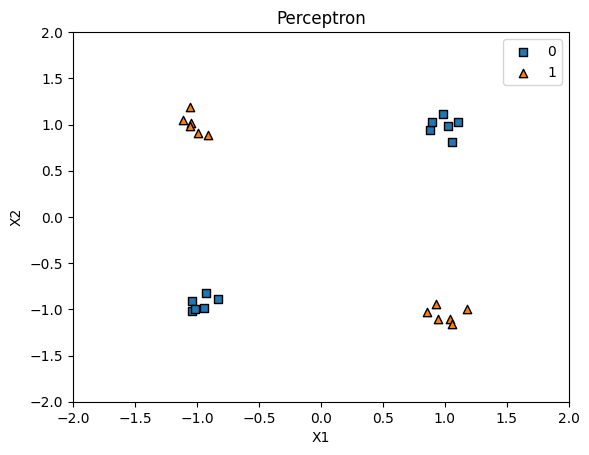

In [8]:
show_non_linear_data()

If we fit the Perceptron on this dataset, the following happens:

In [9]:
show_nonlinear_model(interactive=False)

Output()

### 1.1.5 Assignment - Classic, single-layer Perceptron Limit

**Assignment 1:** Is the final model good? What went wrong? Does more training help? Does more data (more rectangles and circles) help? Use the simulation below to understand better if you find it hard to answer the questions. The method trains for three epochs, meaning it loops over all data points $3$ times.

In [11]:
show_nonlinear_model(interactive=True)

<font color='red'>Solution Assignment 1</font>

The final model is not good, as it does not discriminate the orange rectangular data well from the blue rectangles. The reason is that the single-layer Perceptron is a linear model; it can, therefore, discriminate data points only linearly. In two dimensions, the decision boundary is a line. But here, no line separates the data points well, so a linear model is a wrong design choice. Given the learning algorithm, we could train the model infinitely, but it never learns to separate the data well. Additionally, no amount of data will solve this inherent limitation.

### 1.1.6 How to solve non-linear data with a Perceptron?

There are two standard solutions to learning non-linear relationships.

1. Add the non-linearity into the inputs using **manual feature engineering**.
We can add a new feature, $x_3$, a non-linear combination of the previous features $x_1$ and $x_2$. Using $x_3$, then the model can learn non-linear functions in $x_1$ and $x_2$ through $x_3$. For example, we can manually create $x_3 = x_1 * x_2$ and provide it as an additional input of the Perceptron model. The Perceptron can use this extra input to learn the following function (see code below).

2. Make **extra neurons** (called hidden neurons) $z$ between the output $y$ and input $x$ that **learn autonomously a feature representation** given enough data.
This can also be done for Perceptrons, using binary neurons and a custom learning algorithm. Today, this is generally done using a **feed-forward neural network**, the successor to Perceptrons, where neurons are customizable using a custom activation function rather than binary and use gradient descent to learn. We will discuss this in the next section.

**Assignment 2:**
Below, we use the 1. Solution by adding manual feature engineering.
In the code, we do not just input $x_1$ and $x_2$ to the model, but also $x_3=x_1*x_2$.
Run the code below. What is different? Does the model now work? Why?

In [12]:
# 1. Solution

show_nonlinear_model(interactive=True, feature_engineering=True)

<font color='red'>Solution Assignment 2</font>

The model works successfully in discriminating the orange triangles from the blue rectangles. Given $x_3 = x_2 * x_1$, the model can learn a non-linear decision boundary in the input space of $x_1$ and $x_2$. For example, the model would learn the following:

$$y = h(x_1 * 2 + x_2 * 2 + x_3 * -3)$$

Which is equivalent to (inserting definition of $x_3$):

$$
y = h(x_1 * 2 + x_2 * 2 + x_1 * x_2 * -3)
$$

Now:
* If we insert $x_1=+1$ and $x_2=+1$ (top right), we predict blue because $h(+1)=1$.
* If we insert $x_1=-1$ and $x_2=+1$ (top left), we predict orange because $h(-3)=0$.
* If we insert $x_1=+1$ and $x_2=-1$ (bottom right), we predict orange because $h(-3)=1$.
* If we insert $x_1=-1$ and $x_2=-1$ (bottom left), we predict blue because $h(+1)=0$.

So, the model learns the non-linear XOR-esk function.
(Using the learning rule, the Perceptron may learn a different $\vec{\beta}$, but we prove that there exists a solution by example.)

# 2. Neural Network, Gradient Descent and Backpropagation

## 2.1 (Layer-wise fully connected) neural network

An (artificial) neural network $g$ is **loosely inspired by biology**.
A neural network is a computational graph with nodes and edges.
Nodes represent neurons that, given their inputs, calculate an output value, applying a non-linear activation function to the weighted inputs. Edges represent input-output connections between the neurons.

Here, we look at the simplest case, a **layer-wise, fully connected network**,
where neurons are grouped in layers and layer-wise fully connected through **directed edges**.
An input signal $x$ travels sequentially from **layer to layer** to calculate a final output $\hat{y}$.
The figure shows a 1-hidden layer neural network, but more hidden layers can be added. The learnable parameters $\beta$ would be on the edges and determine how strongly the source influences the destination neuron.
Compared to the Perceptron, we have a **hidden layer $\vec{z}$** and a general activation function $\phi$.
Considering the last exercise,
such a network could approximate $x_3$ in a hidden layer neuron $\vec{z}$ to successfully classify the data.

![image.png](https://github.com/ManteLab/ItoN_notebooks_public/blob/main/utils_ex11/Figures/nn.png?raw=1)

Like the Perceptron, the fully connected neural network learns the parameters $\beta$ (on the edges).
So, the **neurons and neuron connections are fixed**, while the **connection strengths are learned**.
Additionally, the parameters are learned using **gradient descent** to optimize a **single, global loss function** on (training) data.

## 2.2 Learning by optimizing a global loss

In deep learning, we choose a global loss function to measure some performance we want to optimize.
We will update all parameters to optimize this single, global loss function.

For example, in [**supervised learning**](https://en.wikipedia.org/wiki/Supervised_learning), we want to approximate a function $f$ given a bunch of observed inputs $X$ and corresponding outputs $y$.
$f$ is the actual but unknown function, while $\epsilon$ is some noise one can't predict.

$$y = f(X) + \epsilon$$

We now want to model a **neural network $g$ that approximates the unknown function $f$**, such that a model's prediction $\hat{y}$ is close to an actual observed value $y$ given an input $x$.

$$y \approx \hat{y} = g(x)$$

To measure the approximate equal ($\approx$), we decide on a **loss function**, for example, the squared loss:

$$L(y,\ \hat{y})=(y - \hat{y})^2$$

For multiple data points, we assume the **data points to be independent**, meaning we can average their individual errors to get the total loss:

$$
L(y,\ \hat{y}) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

Given this global loss function, we can define the **best approximation $g^*$** to $f$ as the function that minimizes our metric $L(y,\ \hat{y})$ on some (training) data $(X, y)$. This is generally called [Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).
In practice, one must check that $g^*$ does not [overfit](https://en.wikipedia.org/wiki/Overfitting) the noise $\epsilon$, but we ignore this for simplicity.

$$
g^* \coloneqq \underset{g}{\operatorname{arg\,min}}\,\ L(y,\ g(X))
$$

So what did we achieve? **We transformed the learning of a function approximation into an optimization problem**, where many known algorithms exist.
In deep learning, this optimization is done through **first-order algorithms like (mini-batch) gradient descent**.
Specifically, we use gradient descent to update the learnable parameters $\beta$ in our neuron network to minimize a loss $L(y, \hat{y})$.

## 2.3 Gradients and Parameter Updates

Gradient descent works by adjusting the model parameters $\beta$ in the **direction that minimizes the loss function**.
The direction is given by **each parameter's derivative** (gradient) of the loss function (see [multivariate calculus](https://en.wikipedia.org/wiki/Multivariable_calculus)).
First, we calculate each parameter's derivative. For example, the derivative $\frac{\partial L}{\partial \beta^{l}_{i,j}}$ for the learnable parameter $\beta^{l}_{i,j}$, that connects the $i$ neuron in layer $l$ to the $j$ neuron in layer $l+1$. The derivative tells us how to change $\beta^{l}_{i,j}$ to improve the loss $L$.
Putting all parameter's derivatives together $\frac{\partial L}{\partial \beta}$ gives us the **direction in the parameter space to update all parameters simultaneously to reduce the loss $L$**. We ignore interactive effects between the parameters (higher-order derivatives) and optimistically **update all parameters $\beta$ at once**, taking a meaningful step in the direction each would have to be changed in isolation, formally:

$$
\beta \leftarrow \beta - \eta \cdot \frac{\partial L}{\partial \beta}
$$

Where $\eta$ is the learning rate, representing the step size.
Applying this optimization iteratively works well in practice for large neural networks.
Given $10^6$ learnable parameters, we have $10^6$ first-order derivatives $\frac{\partial L}{\partial \beta}$ to calculate.
The **parameter's derivatives can be calculated efficiently using backpropagation** (see next section).
Using the second derivative is infeasible here as $10^{(6+6)}$ second-order derivatives exist.

## 2.4 Assignments: Simulation: Neural Network and Gradient Descent

Below, we have a **two-hidden layer** (layer-wise fully connected) neural network that we train on some synthetically generated data.

**Assignment 3**: The cell below shows the gradient descent learning algorithm in action. What do we see in the `Model` plot, and what is the `Loss` plot? `Generate Animation`  can take a few minutes, but afterward, we can step through all the frames representing the gradient descent steps ($
\beta \leftarrow \beta - \eta \cdot \frac{\partial L}{\partial \beta}
$).

**Assignment 4**: What happens if we reduce or increase the `learning rate`? Why does a (too) small learning rate not work here? Why does a (too) large learning rate not work here?

In [13]:
iplot_gn_model()

<font color='red'>Solution Assignment 3</font>

At each iteration, we have parameters $\beta$, and therefore, we have a neural network model.

The first plot shows the current model (green) and previous models (transparent orange).
Initially, the model is poor, but it improves iteratively through gradient descent optimization.

The second plot shows the loss function $L(y, g(X))$ over the iterations (epochs), so technically, the performance of all models.
If the loss function decreases, the learning works.

<font color='red'>Solution Assignment 4</font>

The simulation shows a gradient descent iteration following the formula:

$$
\beta \leftarrow \beta - \eta \cdot \frac{\partial L}{\partial \beta}
$$

Technically, this function is applied multiple times per iteration using an approximation for $\frac{\partial L}{\partial \beta}$ (called mini-batch gradient descent).

If the learning rate $\eta$ is (too) small, we take a (too) small step each iteration (too pessimistic), leading to longer training time. Increasing the '# epochs' will help, but we waste computing, which becomes impractical for bigger networks.

If the learning rate $\eta$ is (too) big, we take a (too) big step each iteration (too optimistic), leading to divergence.
Divergence means we take too big of a step in the parameter space and decrease performance. Along with worse performance, the gradient's magnitude usually rises, leading to an accumulative effect with worse and worse performance (divergence).

## 2.5 Backpropagation

We can calculate the **derivative for each parameter $\frac{\partial L}{\partial \beta}=[\frac{\partial L}{\partial \beta^{(0)}_{0,0}, }\frac{\partial L}{\partial \beta^{(0)}_{0,1}, },...\frac{\partial L}{\partial \beta^{(1)}_{0,0}, },...]$ efficiently using backpropagation**.
Backpropagation goes **backward through the neural network and loss function** to calculate each parameter's derivative while **caching** shared terms. We won't go into the maths here as it is primarily about using the associativity and distributivity of the chain rule to reuse shared terms. Instead, we try to understand backpropagation intuitively using a simple computational graph.
Note that the **mechanism stays the same for more complex computational graphs** (like neural networks).

## 2.5.1 Assignments: Simulation: Backpropagation

**Assignment 5:** The following demo runs the forward pass (prediction) through the computational graph first, followed by the backward pass (backpropagation). During the forward pass, the intermediate data results are computed and stored for the backward pass. The gradients for each intermediate result (shared term) and learnable parameter $w$ are calculated during the backward pass. Run the demo. Explain what happens.

In [14]:
backprop()

<font color='red'>Solution Assignment 5</font>

First, the forward pass happens. During the forward pass, the neural network runs operation by operation until it reaches the output. Along the path, the intermediate results are cached (`data`) for later.

After the forward pass, the backward pass happens. During the backward pass, the neural network runs backward, calculating the derivatives of each operation to the loss stored in (`grad`) for later.

After the backward pass, we can look into all parameter nodes ($w$ nodes) to get the specific gradient. For example, in the node $w_1$, we see that the gradient $\frac{\delta w_1}{\delta L}$ is $-18.08$.

Note that we do not visualize the individual mathematical operations here, but they would just be the chain rule from Analysis.

## 2.6 Closing

Ignoring some technical aspects, such as including [momentum](https://en.wikipedia.org/wiki/Gradient_descent#Momentum_or_heavy_ball_method) and [training batches](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), the **shown mechanism is how artificial neural networks are trained**. We run a forward pass to calculate intermediate values (`data`) and then run backward to the derived version of the network to calculate the gradients (`grad`) for intermediates (e.g., `x1*w1`) for reuse/caching and parameters (e.g., `w1`) (for the later gradient descent step).

In practice, we don't have to implement this algorithm ourselves as it can be generalized to any neural network architecture using **[automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)**.

# 3. Feature Learning

Now that we better understand the mechanism behind neural networks let's try to sharpen our intuition using a popular demo.

## 3.1 Assignment Feature Learning

**Assignment 6:** Visit [https://playground.tensorflow.org](https://playground.tensorflow.org). Play around with the demo. Play around with the learning rate, the activation, the number of layers and hidden units as well as the data.

**Assignment 7:** Visit [this configuration](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.00001&regularizationRate=0&noise=0&networkShape=&seed=0.40739&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) and try to make the network learn a good approximation without changing the data configuration. What did you have to change?

<font color='red'>Solution Assignment 6</font>

No Solution.

<font color='red'>Solution Assignment 7</font>

There are currently two problems. First, we have no hidden layer and a non-linear problem. Second, the learning rate is too small, hindering training.

A possible solution is the following:
Add a hidden layer with, e.g., eight neurons, so the model can learn non-linear relationships and increase the learning rate to $0.1$.
Here, we hidden layer learns helpful features.

[Solution](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=8&seed=0.40739&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

Another possible solution is the following:
Don't add a hidden layer, but the non-linear features $x_1^2$ and $x_2^2$ (called feature engineering), and increase the learning rate to $0.1$. Here, we manually craft the feature learning, and the model only learns to weigh those features.

[Solution](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=&seed=0.40739&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=true&ySquared=true&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

# 4. GANs

## 4.1 GAN Modell

In this part, we look into more realistic Deep Learning.
More concretely, we **train a simple GAN (Generative Adversarial Network) to generate small pictures** of fashion items.

[Original Source](https://colab.research.google.com/github/timsainb/tensorflow2-generative-models/blob/master/2.0-GAN-fashion-mnist.ipynb#scrollTo=e5i-LWyFxDLO)

A GAN comprises two neural networks: a **generator network** that generates a fake image from random noise and a **discriminator network** that distinguishes generated fake images from actual images from a dataset.
Here is an illustration of this concept:

![gan.png](https://github.com/ManteLab/ItoN_notebooks_public/blob/main/utils_ex11/Figures/gan.png?raw=1)

Here, we use the **Fashion-MNIST dataset**, consisting of small 28*28 grayscale images of fashion items.
The generator and discriminator are **trained together using backpropagation** on the following loss function:

$$
L = L_D + L_G
$$

$L_D$ is the discriminator loss and $L_G$ is the generator loss.

<details>
<summary>Extra Details</summary>
    
Formally, they are:

$$
L_D = \mathbb{E}_{x \sim p_{\text{data}}} \left[ \log D(x) \right] + \mathbb{E}_{z \sim p_z} \left[ \log (1 - D(G(z))) \right]
$$

$$
L_G = \mathbb{E}_{z \sim p_z} \left[ \log D(G(z)) \right]
$$

Intuitively, $L_D$ describes how bad the discriminator detects fake images from the generator $G$, whereas $L_G$ describes how good the fake images are (by fooling the discriminator $D$). $p_z$ is a simple distribution to sample from, e.g., a standardized normal distribution. $p_{data}$ is our dataset Fashion-MNIST.
One can imagine losses as a game where $G$ wins if the fakes are too good for $D$ to distinguish, and $D$ wins if it is better at distinguishing fakes than $G$ is at generating fakes. $G$ and $D$ are trained together and learn through this adversarial loss to both improve.

Another interesting perspective is to see $D$ as a learnable, changing loss function for $G$. Rather than using a fixed loss function that $G$ can start to exploit, the loss function $D$ is trained along $G$ to be competitive with it.
Using backpropagation through $D$, we get meaningful gradients on the outputs of $G$, indicating how $G$'s output must be changed to better fool $D$.

</details>

## 4.2 Assignment GAN

**Assignment 8:** Run this code cell. The cell that trains the model should take around 15 minutes (around 20 seconds per epoch).

**Assignment 9:** Investigate the generator and discriminator summaries. They show each layer in the architecture as a row in a table describing the output shapes and the number of parameters. You are not expected to understand the architecture, but we can understand some aspects. How are the generator and discriminator connected? How many total parameters does our architecture have?  

**Assignment 10:** The cell with the `plot_gan` function shows the output during the training. You can use the slider (after training is completed) to see intermediate-generated images. Investigate the results.

**Assignment 11:** Investigate the plot of the loss function.

In [10]:
generator, discriminator = get_models()

In [11]:
generator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3136)                │         203,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 259,521 (1013.75 KB)

 Trainable params: 259,521 (1013.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
discriminator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 13, 13, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 6, 6, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           2,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,121 (82.50 KB)

 Trainable params: 21,121 (82.50 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
%matplotlib inline
losses = plot_gan(generator, discriminator)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


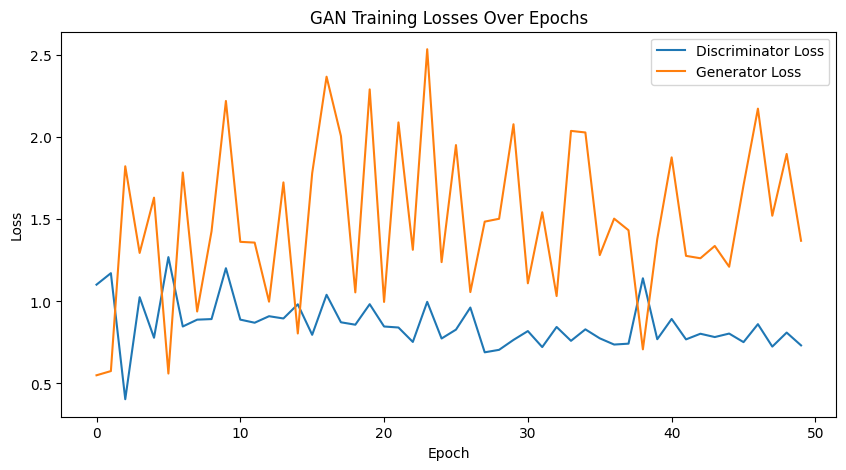

In [14]:
plot_losses(losses)

<font color='red'>Solution Assignment 8</font>

No Solution.

<font color='red'>Solution Assignment 9</font>

The generator starts with 64 inputs. To generate different outputs, those inputs are randomly drawn from a Gaussian (not shown in the summary). The generator's output is a grayscale image with 28*28 pixels (output shape is (28, 28, 1)). The "None" in front would be the batch dimension, which we ignore here. This generated image (or an actual image) is given to the discriminator, which starts with the matching input shape. The output is a single unit, which is the logit for the discrimination ("real" or "fake" prediction).

Our generator has $259,521$ parameters. Our discriminator has $21,121$ parameters.
Therefore, in total, our architecture has $280,642$ parameters.

<font color='red'>Solution Assignment 10</font>

Different runs can have other images of varying quality in the end.
In general, the generated images should look okay.
While a human may still distinguish them from real images, the model learned some aspects of how to generate fake images.

<font color='red'>Solution Assignment 11</font>

The losses stay more or less stable (can differ from different runs).
For GANs, this is not unusual as the generator $G$ and discriminator $D$ compete with each other, so they make it more difficult for each other, which seems to balance out here.


# 5. Pre-Trained GANs

In this exercise, we’ll explore a **pre-trained conditional GAN model**, specifically using the **BigGAN model**, to **generate images based on text descriptions**.
What is a Conditional GAN?

## 5.1 Conditional GANs

A conditional GAN differs from a non-conditional GAN by adding a “condition” that directs the generator to **produce images based on a given input** (e.g., text or a label). This input acts as a **guide for the generator**. In this exercise, we’ll use BigGAN, a pre-trained conditional GAN, which takes a text input (a class label, like "dog" or "car") and generates an image matching that description.

Here’s how it works:

* Input a Text Prompt: BigGAN expects a word or label as input, representing the type of image you want to generate (e.g., "cat" or "mountain").
* Generate an Image: BigGAN will use its learned associations between labels and image features to create an image that reflects the prompt.
* Observe the Results: This exercise demonstrates how a conditional GAN can control the content of generated images based on the input condition.

## 5.2 Assignments: Conditional GANs

**Assignment 12:** Run the provided code to load the BigGAN model.

**Assignment 13:** Enter a text label for the type of image you want (e.g., "horse"). Note that only a limited of labels are supported. Use "Generate random..." to get a random supported label. You can also use the same label multiple times as the generated images differ always starting from a random vector.

**Assignment 14:** Generate the image and view the result.

**Assignment 15:** Experiment with different labels to see the variety of images BigGAN can create.
Example Labels to Try
* Animals: “dog,” “cat,"
* Nature: “mountain”
* Objects: “car,” “bicycle,” “piano”

The model used: [https://github.com/huggingface/pytorch-pretrained-BigGAN](https://github.com/huggingface/pytorch-pretrained-BigGAN)

In [15]:
gan_pretrain()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
100%|██████████| 715/715 [00:00<00:00, 530314.30B/s]
/usr/local/lib/python3.10/dist-packages/pytorch_pretrained_biggan/model.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weigh

<font color='red'>Solution Assignment 12</font>

No Solution.

<font color='red'>Solution Assignment 13</font>

No Solution.

<font color='red'>Solution Assignment 14</font>

No Solution.

<font color='red'>Solution Assignment 15</font>

No Solution.